# Section 1:  Removal of bias in embedding (`Word2Vec`)

In [33]:
import gensim.downloader as api
import numpy as np

In [ ]:
wv = api.load("word2vec-google-news-300")

In [5]:
king = wv["king"]
print(king.shape)

(300,)


In [6]:
print(wv.most_similar(positive=["king", "queen"], topn=10))

[('monarch', 0.7042065858840942), ('kings', 0.6780861020088196), ('princess', 0.6731551289558411), ('queens', 0.6679497957229614), ('prince', 0.6435247659683228), ('royal', 0.5985592603683472), ('princes', 0.5942345261573792), ('crown_prince', 0.5906674265861511), ('NYC_anglophiles_aflutter', 0.5811060070991516), ('Queen_Consort', 0.5735104084014893)]


In [7]:
print(wv.similarity("king", "queen" ))

0.6510957


In [50]:
print(wv.most_similar(positive=["man", "rule"], negative=["woman"]))

[('rules', 0.5407542586326599), ('ruled', 0.44207143783569336), ('Fifa_statutes', 0.4358542859554291), ('Rule', 0.42790597677230835), ('rulebook', 0.40312427282333374), ('Gensym_flagship_G2', 0.39585864543914795), ('unwritten_pact', 0.3956116735935211), ('edict', 0.3861566483974457), ('dictum', 0.3820774257183075), ('Bosman_Ruling', 0.37687504291534424)]


### Debias by Neutralization

In [45]:
def debias(word_with_bias, word_positive, word_negative, wv):
    biased = wv[word_with_bias]
    positive = wv[word_positive]
    negative = wv[word_negative]
    dist = positive - negative
    
    bias_component = np.dot(biased, dist) / np.sum(dist * dist) * dist
    return biased - bias_component

In [46]:
rule_debiased = debias("rule", "man", "woman", wv)

Before:

In [8]:
print(wv.most_similar(positive=["man", "rule"], negative=["woman"]))

[('rules', 0.5407542586326599), ('ruled', 0.44207143783569336), ('Fifa_statutes', 0.4358542859554291), ('Rule', 0.42790597677230835), ('rulebook', 0.40312427282333374), ('Gensym_flagship_G2', 0.39585864543914795), ('unwritten_pact', 0.3956116735935211), ('edict', 0.3861566483974457), ('dictum', 0.3820774257183075), ('Bosman_Ruling', 0.37687504291534424)]


After:

In [49]:
print(wv.most_similar(positive=["man", rule_debiased], negative=["woman"]))

[('rule', 0.9792402982711792), ('rules', 0.6320737600326538), ('Rule', 0.513302206993103), ('ruled', 0.512016773223877), ('Fifa_statutes', 0.48751938343048096), ('law', 0.4780648350715637), ('Gensym_flagship_G2', 0.4628755450248718), ('ruling', 0.4611573815345764), ('rulebook', 0.4580633044242859), ('edict', 0.45712146162986755)]


## Section 2: Sentiment Analysis

In [ ]:
import os
import numpy as np
import multiprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import preprocessing
from tensorflow.keras.datasets import imdb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

In [307]:
def analyze_imdb_sentiment(MAX_SEQUENCE_LEN=100, EMBEDDED_SIZE=8):
    MAX_FEATURES = 10000
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    
    # x_train has a size (training_size, ). Because the sentences have variable size,
    # we cannot represent this in matrix format.
    print(x_train.shape)
    
    # We do that by "padding" the sentences. If the sentences are bigger, we clip them.
    # If they are smaller, we insert a "NO_WORD" token to the sentence.
    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LEN)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LEN)
    print(x_train.shape)
    
    xi = Input(MAX_SEQUENCE_LEN)

    # Embedding input is (training_size, MAX_SEQUENCE_LEN)
    # Embedding output is (training_size, MAX_SEQUENCE_LEN, EMBEDDED_SIZE)

    x = Embedding(MAX_FEATURES, EMBEDDED_SIZE, input_length=MAX_SEQUENCE_LEN)(xi)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=xi, outputs=x)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
    model.summary()

    history = model.fit(
            x_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
            workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)

    print(model.evaluate(x_test, y_test))


In [308]:
analyze_imdb_sentiment()

(25000,)
(25000, 100)
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_50 (Embedding)     (None, 100, 8)            80000     
_________________________________________________________________
flatten_30 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 801       
Total params: 80,801
Trainable params: 80,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 2s 77us/sample - loss: 0.5996 - acc: 0.6816 - val_loss: 0.4171 - val_acc: 0.8284
Epoch 2/20
20000/20000 [==================

The current accuracy for this model is **0.8292**

Try to add a preloaded embedded from Glove from this model, see the suggestion in
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

Also try Conv1D + MaxPooling1D to improve results


In [342]:
def analyze_imdb_sentiment2(max_sequence_len=100, embedded_size=100, weights=None):
    MAX_FEATURES = 10000
    
    if weights is None:
        weights = get_embedding_weight(embedded_size, MAX_FEATURES)
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    
    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_sequence_len)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_sequence_len)

    
    xi = Input(max_sequence_len)

    # Embedding input is (training_size, max_sequence_len)
    # Embedding output is (training_size, max_sequence_len, embedded_size)

    x = Embedding(MAX_FEATURES, embedded_size, input_length=max_sequence_len,
              weights=[weights], trainable=True)(xi)
    x = Conv1D(100, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Flatten()(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=xi, outputs=x)

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
    model.summary()

    history = model.fit(
            x_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
            workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)
    
    evalutation = model.evaluate(x_test, y_test)
    print(evalutation)
    return evalutation

In [337]:
def get_embedding_weight(embedded_size, max_features):
    embeddings_index, embedding_pretrain_size = load_pretrained_embedding_idx(embedded_size)
    
    assert embedding_pretrain_size >= embedded_size
    
    return get_embedding_matrix(
        imdb.get_word_index(),
        embeddings_index,
        MAX_FEATURES,
        embedded_size)

In [312]:
def load_pretrained_embedding_idx(dimension):
    assert dimension in [50, 100, 200, 300]
    CURR_DIR   = os.getcwd()
    PRETRAINED = 'glove.6B.%dd.txt' % dimension
#     PRETRAINED = 'glove.42B.%dd.txt' % dimension
    
    embeddings_index = {}
    
    with open(os.path.join(CURR_DIR, PRETRAINED), "r") as fd:
        for line in fd:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        
    return embeddings_index, dimension

In [336]:
def get_embedding_matrix(word_index, embeddings_index, max_features, embedded_size):
    embedding_matrix = np.zeros((max_features, embedded_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [333]:
analyze_imdb_sentiment2(embedded_size=200)

Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
embedding_66 (Embedding)     (None, 100, 200)          2000000   
_________________________________________________________________
conv1d_124 (Conv1D)          (None, 96, 100)           100100    
_________________________________________________________________
max_pooling1d_109 (MaxPoolin (None, 19, 100)           0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 1900)              0         
_________________________________________________________________
dense_80 (Dense)             (None, 1)                 1901      
Total params: 2,102,001
Trainable params: 2,102,001
Non-trainable params: 0
________________________________________________

The accuracy of this model improves to **0.83484**

> Question: why does this model may help you get better accuracy?
 
The model may improve because it loads a pretrained embedding as its weight and also has some "additional weights" (Conv1D, pooling) on top of the embedding.

Now, try to change the `max_sequence_len` or the `embedded_size` and plot a 3D graph with
`embedded_size` x `max_sequence_len` x `accuracy` in a python jupyter notebook.

In [340]:
def train_combination():
    MAX_FEATURES = 10000

    result = []
    for embedded_size in [50, 100, 200, 300]:
        weights = get_embedding_weight(embedded_size, MAX_FEATURES)
        for max_sequence_len in [50, 100, 200, 300]:
            _, accuracy = analyze_imdb_sentiment2(max_sequence_len, embedded_size, weights)
            result.append((embedded_size, max_sequence_len, accuracy))
            
    return result

In [370]:
def plot_3d(data):
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=data[:,0], 
        ys=data[:,1], 
        zs=data[:,2], 
        c=data[:,1], 
        cmap='tab10'
    )
    ax.set_xlabel("Embedded size")
    ax.set_ylabel("Max sequence length")
    ax.set_zlabel("Accuracy")
    plt.show()

In [343]:
res = train_combination()

Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_67 (Embedding)     (None, 50, 50)            500000    
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 46, 100)           25100     
_________________________________________________________________
max_pooling1d_110 (MaxPoolin (None, 9, 100)            0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 900)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 901       
Total params: 526,001
Trainable params: 526,001
Non-trainable params: 0
____________________________________________________

25000/25000 [==============================] - 1s 35us/sample - loss: 1.1373 - acc: 0.8228
[1.1373093805336951, 0.8228]
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_69 (Embedding)     (None, 200, 50)           500000    
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 196, 100)          25100     
_________________________________________________________________
max_pooling1d_112 (MaxPoolin (None, 39, 100)           0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 3900)              0         
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 3901      
Tota

25000/25000 [==============================] - 1s 53us/sample - loss: 0.9815 - acc: 0.8581
[0.9815400265074335, 0.85812]
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_71 (Embedding)     (None, 50, 100)           1000000   
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 46, 100)           50100     
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 9, 100)            0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 900)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 901       
Tot

Epoch 19/20
20000/20000 [==============================] - 5s 252us/sample - loss: 2.0775e-05 - acc: 1.0000 - val_loss: 1.0091 - val_acc: 0.8372
Epoch 20/20
25000/25000 [==============================] - 1s 42us/sample - loss: 1.0670 - acc: 0.8289
[1.0670092479228974, 0.82888]
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_73 (Embedding)     (None, 200, 100)          1000000   
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 196, 100)          50100     
_________________________________________________________________
max_pooling1d_116 (MaxPoolin (None, 39, 100)           0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 3900)   

Epoch 18/20
20000/20000 [==============================] - 6s 308us/sample - loss: 2.0930e-05 - acc: 1.0000 - val_loss: 0.8411 - val_acc: 0.8730
Epoch 19/20
20000/20000 [==============================] - 6s 317us/sample - loss: 1.4635e-05 - acc: 1.0000 - val_loss: 0.8680 - val_acc: 0.8740
Epoch 20/20
25000/25000 [==============================] - 2s 70us/sample - loss: 0.9216 - acc: 0.8629
[0.9216068066444993, 0.86288]
Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        [(None, 50)]              0         
_________________________________________________________________
embedding_75 (Embedding)     (None, 50, 200)           2000000   
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 46, 100)           100100    
_________________________________________________________________
max_pooling1d_118 (MaxPoolin (N

Epoch 17/20
20000/20000 [==============================] - 9s 427us/sample - loss: 2.3527e-05 - acc: 1.0000 - val_loss: 0.9010 - val_acc: 0.8348
Epoch 18/20
20000/20000 [==============================] - 8s 425us/sample - loss: 1.6373e-05 - acc: 1.0000 - val_loss: 0.9338 - val_acc: 0.8332
Epoch 19/20
20000/20000 [==============================] - 9s 431us/sample - loss: 1.1541e-05 - acc: 1.0000 - val_loss: 0.9550 - val_acc: 0.8358
Epoch 20/20
25000/25000 [==============================] - 1s 50us/sample - loss: 0.9866 - acc: 0.8334
[0.9866413041234017, 0.8334]
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_79 (InputLayer)        [(None, 200)]             0         
_________________________________________________________________
embedding_77 (Embedding)     (None, 200, 200)          2000000   
_________________________________________________________________
conv1d_135 (Conv1D)

20000/20000 [==============================] - 12s 605us/sample - loss: 6.0749e-05 - acc: 1.0000 - val_loss: 0.8033 - val_acc: 0.8398
Epoch 14/20
20000/20000 [==============================] - 12s 613us/sample - loss: 4.2475e-05 - acc: 1.0000 - val_loss: 0.8294 - val_acc: 0.8376
Epoch 15/20
20000/20000 [==============================] - 13s 638us/sample - loss: 2.9490e-05 - acc: 1.0000 - val_loss: 0.8548 - val_acc: 0.8374
Epoch 16/20
20000/20000 [==============================] - 12s 608us/sample - loss: 2.0665e-05 - acc: 1.0000 - val_loss: 0.8802 - val_acc: 0.8380
Epoch 17/20
20000/20000 [==============================] - 12s 609us/sample - loss: 1.4553e-05 - acc: 1.0000 - val_loss: 0.9046 - val_acc: 0.8386
Epoch 18/20
20000/20000 [==============================] - 12s 613us/sample - loss: 1.0236e-05 - acc: 1.0000 - val_loss: 0.9277 - val_acc: 0.8394
Epoch 19/20
20000/20000 [==============================] - 12s 617us/sample - loss: 7.2471e-06 - acc: 1.0000 - val_loss: 0.9507 - val_ac

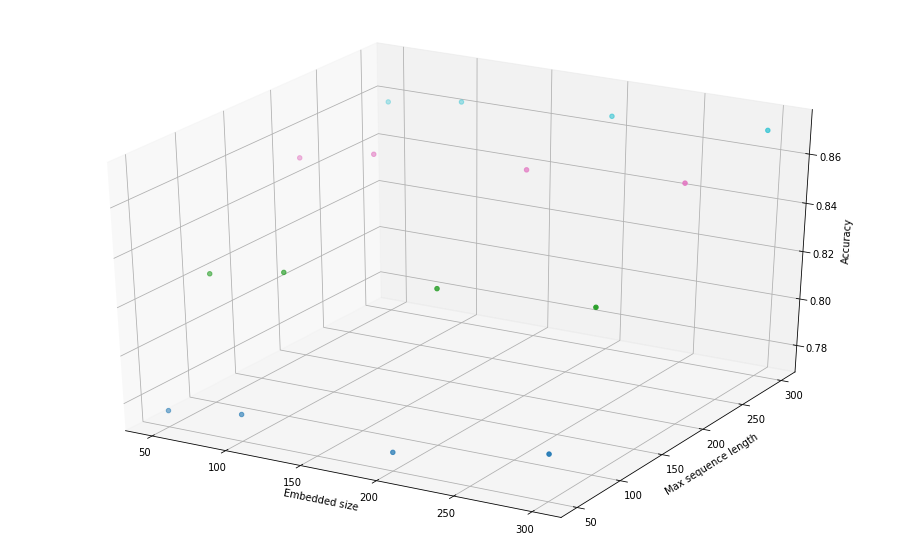

In [373]:
plot_3d(np.asarray(res))

# The longer max sequence length is, the more accuracy we can achieve.

## Section 3: Sentiment Analysis with `LSTM`

In [228]:
import multiprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from tensorflow.keras.datasets import imdb

In [486]:
MAX_FEATURES = 10000
MAX_SEQUENCE_LEN = 300
EMBEDDED_SIZE = 300

In [487]:
# Load imdb dataset and print a few samples to check.
#
# IMDB: sentence (x) -> positive/negative (y)
#
# “The food was really good” 				 -> pos
# “The chicken crossed the road because it was uncooked” -> neg

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)

# x_train has a size (training_size, ). Because the sentences have variable size,
# we cannot represent this in matrix format.

print(x_train.shape)

# The first step is to make the column size constant.
#
# We do that by "padding" the sentences. If the sentences are bigger, we clip them.
# If they are smaller, we insert a "NO_WORD" token to the sentence.

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=MAX_SEQUENCE_LEN)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=MAX_SEQUENCE_LEN)

print(x_train.shape)

# Let's see the first sentence

print(x_train[0])

# Input shape should be now (training_size, MAX_SEQUENCE_LEN)

(25000,)
(25000, 300)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    1   14
   22   16   43  530  973 1622 1385   65  458 4468   66 3941    4  173
   36  256    5   25  100   43  838  112   50  670    2    9   35  480
  284    5  150    4  172  112  167    2  336  385   39    4  172 4536
 1111   17  546   38   13  447    4  192   50   16    6  147 2025   19
   14   22    4 1920 4613  469    4   22   71   87   12   16   43  530
   38   76   15   13 1247    4   22   17  515   17   12   16  626   18
    2    5   62  386   12    8  316    8  106    5    4 2223 5244   16
  480   66 3785   33    4  130   12   16   38  619    5

*“The chicken crossed the road because it was uncooked”*

```
h0 -> The 		-> h1
h1 -> chicken 	-> h2
h2 -> crossed 	-> h3
h3 -> the 		-> h4
h4 -> road		-> h5
h5 -> because		-> h6
h6 -> it		-> h7
h7 -> was		-> h8
h8 -> uncooked	-> h9
h9 -> pos
```

`return_sequences`: Boolean. Whether to return the last output in the output
    sequence, or the full sequence.
`return_state`: Boolean. Whether to return the last state in addition to the
    output. The returned elements of the states list are the hidden state
    and the cell state, respectively.
    
> What's the difference between `return_sequences` and `return_state`?

`return_sequences` returns the full sequence of output to each input, while `return_state` returns the last state of the hidden state and and the cell state.

In [512]:
def get_embedding_weight(embedded_size, max_features):
    embeddings_index, embedding_pretrain_size = load_pretrained_embedding_idx(embedded_size)
    
    assert embedding_pretrain_size >= embedded_size
    
    return get_embedding_matrix(
        imdb.get_word_index(),
        embeddings_index,
        max_features,
        embedded_size)

In [513]:
def load_pretrained_embedding_idx(dimension):
    assert dimension in [50, 100, 200, 300]
    CURR_DIR   = os.getcwd()
    PRETRAINED = 'glove.6B.%dd.txt' % dimension
#     PRETRAINED = 'glove.42B.%dd.txt' % dimension
    
    embeddings_index = {}
    
    with open(os.path.join(CURR_DIR, PRETRAINED), "r") as fd:
        for line in fd:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        
    return embeddings_index, dimension

In [514]:
def get_embedding_matrix(word_index, embeddings_index, max_features, embedded_size):
    embedding_matrix = np.zeros((max_features, embedded_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

Using `LSTM` to classify sentence as positive or negative

Try to get accuracy on validation set over 90%.

In [523]:
def analyze_imdb_sentiment_lstm(
    max_sequence_len=300,
    embedded_size=300,
    weights=None,
    use_weight=False):
    MAX_FEATURES = 10000
    
    if use_weight and weights is None:
        weights = get_embedding_weight(embedded_size, MAX_FEATURES)
    
    (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=MAX_FEATURES)
    
    x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=max_sequence_len)
    x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=max_sequence_len)

    
    xi = Input(max_sequence_len)

    if use_weight:
        x = Embedding(MAX_FEATURES, embedded_size, input_length=max_sequence_len,
              weights=[weights])(xi)
    else:
        x = Embedding(MAX_FEATURES, embedded_size, input_length=max_sequence_len)(xi)

    x = Conv1D(300, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)

    x = SpatialDropout1D(0.4)(x)

    x = LSTM(280, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = LSTM(160, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = LSTM(50, dropout=0.2, recurrent_dropout=0.2)(x)

    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=xi, outputs=x)

    optimizer = Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["acc"])
    model.summary()

    history = model.fit(
            x_train, y_train, epochs=20, batch_size=32, validation_split=0.2,
            workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)

    evalutation = model.evaluate(x_test, y_test,
                                 workers=(multiprocessing.cpu_count() - 1),
                                 use_multiprocessing=True)
    print(evalutation)
    return evalutation

In [520]:
def train_combination():
    MAX_FEATURES = 10000

    result = []
    for embedded_size in [50, 100, 200, 300]:
        for max_sequence_len in [50, 100, 200, 300]:
            _, accuracy = analyze_imdb_sentiment_lstm(max_sequence_len, embedded_size)
            result.append((embedded_size, max_sequence_len, accuracy))
            
    return result

In [521]:
def plot_3d(data):
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=data[:,0], 
        ys=data[:,1], 
        zs=data[:,2], 
        c=data[:,1], 
        cmap='tab10'
    )
    ax.set_xlabel("Embedded size")
    ax.set_ylabel("Max sequence length")
    ax.set_zlabel("Accuracy")
    plt.show()

In [524]:
res = train_combination()

# The highest validation accuracy we achieved here was 89.46%

Model: "model_166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_193 (InputLayer)       [(None, 50)]              0         
_________________________________________________________________
embedding_176 (Embedding)    (None, 50, 50)            500000    
_________________________________________________________________
conv1d_221 (Conv1D)          (None, 46, 300)           75300     
_________________________________________________________________
max_pooling1d_204 (MaxPoolin (None, 9, 300)            0         
_________________________________________________________________
spatial_dropout1d_40 (Spatia (None, 9, 300)            0         
_________________________________________________________________
lstm_292 (LSTM)              (None, 9, 280)            650720    
_________________________________________________________________
lstm_293 (LSTM)              (None, 9, 160)            28

20000/20000 [==============================] - 95s 5ms/sample - loss: 0.0251 - acc: 0.9932 - val_loss: 0.6113 - val_acc: 0.8672
Epoch 10/20
20000/20000 [==============================] - 95s 5ms/sample - loss: 0.0262 - acc: 0.9924 - val_loss: 0.5662 - val_acc: 0.8704
Epoch 11/20
20000/20000 [==============================] - 97s 5ms/sample - loss: 0.0225 - acc: 0.9931 - val_loss: 0.5820 - val_acc: 0.8680
Epoch 12/20
20000/20000 [==============================] - 95s 5ms/sample - loss: 0.0212 - acc: 0.9942 - val_loss: 0.6080 - val_acc: 0.8666
Epoch 13/20
20000/20000 [==============================] - 95s 5ms/sample - loss: 0.0187 - acc: 0.9947 - val_loss: 0.6208 - val_acc: 0.8670
Epoch 14/20
20000/20000 [==============================] - 95s 5ms/sample - loss: 0.0166 - acc: 0.9961 - val_loss: 0.6090 - val_acc: 0.8662
Epoch 15/20
20000/20000 [==============================] - 96s 5ms/sample - loss: 0.0153 - acc: 0.9959 - val_loss: 0.6817 - val_acc: 0.8662
Epoch 16/20
20000/20000 [=======

Epoch 3/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.1768 - acc: 0.9352 - val_loss: 0.4247 - val_acc: 0.8404
Epoch 4/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.1175 - acc: 0.9588 - val_loss: 0.4663 - val_acc: 0.8418
Epoch 5/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.0737 - acc: 0.9762 - val_loss: 0.5776 - val_acc: 0.8288
Epoch 6/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.0486 - acc: 0.9854 - val_loss: 0.5726 - val_acc: 0.8370
Epoch 7/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.0423 - acc: 0.9878 - val_loss: 0.6143 - val_acc: 0.8318
Epoch 8/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.0329 - acc: 0.9892 - val_loss: 0.7393 - val_acc: 0.8318
Epoch 9/20
20000/20000 [==============================] - 36s 2ms/sample - loss: 0.0285 - acc: 0.9912 - val_loss: 0.7916 - val_acc: 0.8320
Epoch 10/20
20000/20000 [==

20000/20000 [==============================] - 101s 5ms/sample - loss: 0.4207 - acc: 0.7934 - val_loss: 0.2782 - val_acc: 0.8908
Epoch 2/20
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.2293 - acc: 0.9115 - val_loss: 0.2855 - val_acc: 0.8850
Epoch 3/20
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.1585 - acc: 0.9439 - val_loss: 0.3067 - val_acc: 0.8824
Epoch 4/20
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.1030 - acc: 0.9645 - val_loss: 0.3348 - val_acc: 0.8790
Epoch 5/20
20000/20000 [==============================] - 99s 5ms/sample - loss: 0.0706 - acc: 0.9769 - val_loss: 0.4619 - val_acc: 0.8656
Epoch 6/20
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.0496 - acc: 0.9847 - val_loss: 0.4407 - val_acc: 0.8776
Epoch 7/20
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.0403 - acc: 0.9883 - val_loss: 0.4626 - val_acc: 0.8760
Epoch 8/20
20000/20000 [=============

20000/20000 [==============================] - 44s 2ms/sample - loss: 0.4468 - acc: 0.7817 - val_loss: 0.3435 - val_acc: 0.8494
Epoch 2/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.2707 - acc: 0.8918 - val_loss: 0.3519 - val_acc: 0.8478
Epoch 3/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.1765 - acc: 0.9351 - val_loss: 0.4134 - val_acc: 0.8488
Epoch 4/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.1112 - acc: 0.9620 - val_loss: 0.4396 - val_acc: 0.8410
Epoch 5/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.0685 - acc: 0.9785 - val_loss: 0.5780 - val_acc: 0.8384
Epoch 6/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.0495 - acc: 0.9848 - val_loss: 0.5655 - val_acc: 0.8352
Epoch 7/20
20000/20000 [==============================] - 40s 2ms/sample - loss: 0.0444 - acc: 0.9865 - val_loss: 0.5920 - val_acc: 0.8352
Epoch 8/20
20000/20000 [==============

20000/20000 [==============================] - 107s 5ms/sample - loss: 0.4061 - acc: 0.8096 - val_loss: 0.2981 - val_acc: 0.8800
Epoch 2/20
20000/20000 [==============================] - 103s 5ms/sample - loss: 0.2214 - acc: 0.9127 - val_loss: 0.2696 - val_acc: 0.8898
Epoch 3/20
20000/20000 [==============================] - 103s 5ms/sample - loss: 0.1454 - acc: 0.9487 - val_loss: 0.3158 - val_acc: 0.8852
Epoch 4/20
20000/20000 [==============================] - 104s 5ms/sample - loss: 0.0957 - acc: 0.9675 - val_loss: 0.3786 - val_acc: 0.8782
Epoch 5/20
20000/20000 [==============================] - 103s 5ms/sample - loss: 0.0610 - acc: 0.9808 - val_loss: 0.4157 - val_acc: 0.8688
Epoch 6/20
20000/20000 [==============================] - 103s 5ms/sample - loss: 0.0446 - acc: 0.9860 - val_loss: 0.4855 - val_acc: 0.8670
Epoch 7/20
20000/20000 [==============================] - 103s 5ms/sample - loss: 0.0351 - acc: 0.9897 - val_loss: 0.4512 - val_acc: 0.8742
Epoch 8/20
20000/20000 [=======

20000/20000 [==============================] - 49s 2ms/sample - loss: 0.4446 - acc: 0.7818 - val_loss: 0.3564 - val_acc: 0.8368
Epoch 2/20
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.2655 - acc: 0.8949 - val_loss: 0.3592 - val_acc: 0.8438
Epoch 3/20
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.1743 - acc: 0.9349 - val_loss: 0.3978 - val_acc: 0.8422
Epoch 4/20
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.1044 - acc: 0.9657 - val_loss: 0.5133 - val_acc: 0.8450
Epoch 5/20
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.0664 - acc: 0.9775 - val_loss: 0.5301 - val_acc: 0.8388
Epoch 6/20
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.0487 - acc: 0.9843 - val_loss: 0.6089 - val_acc: 0.8364
Epoch 7/20
20000/20000 [==============================] - 45s 2ms/sample - loss: 0.0337 - acc: 0.9900 - val_loss: 0.5970 - val_acc: 0.8414
Epoch 8/20
20000/20000 [==============

20000/20000 [==============================] - 114s 6ms/sample - loss: 0.4188 - acc: 0.8008 - val_loss: 0.2763 - val_acc: 0.8852
Epoch 2/20
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.2213 - acc: 0.9165 - val_loss: 0.2753 - val_acc: 0.8946
Epoch 3/20
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.1458 - acc: 0.9474 - val_loss: 0.3281 - val_acc: 0.8762
Epoch 4/20
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.0961 - acc: 0.9669 - val_loss: 0.3237 - val_acc: 0.8816
Epoch 5/20
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.0613 - acc: 0.9808 - val_loss: 0.3935 - val_acc: 0.8790
Epoch 6/20
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.0457 - acc: 0.9857 - val_loss: 0.4550 - val_acc: 0.8756
Epoch 7/20
20000/20000 [==============================] - 108s 5ms/sample - loss: 0.0361 - acc: 0.9898 - val_loss: 0.5093 - val_acc: 0.8768
Epoch 8/20
20000/20000 [=======

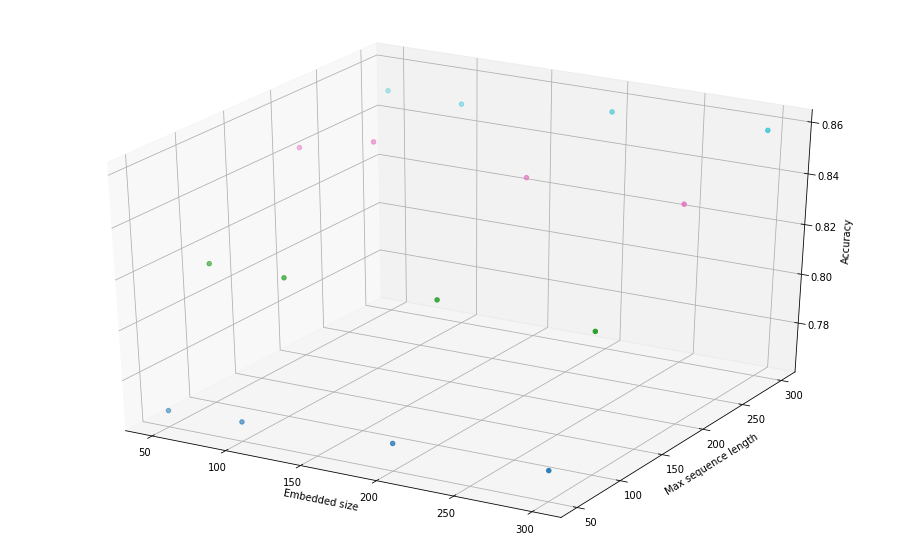

In [525]:
plot_3d(np.asarray(res))

## Section 4: Generating Text

In [1]:
'''Example script to generate text from Nietzsche's writings.

At least 20 epochs are required before the generated text
starts sounding coherent.

It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.

If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import multiprocessing

Using TensorFlow backend.


In [2]:
maxlen = 100

In [3]:
path = get_file("nietzsche.txt",
        origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

text = open(path).read().lower()
print("corpus length:", len(text))

corpus length: 600893


In [4]:
chars = set(text)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 57


In [5]:
# cut the text in semi-redundant sequences of maxlen characters
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print("nb sequences:", len(sentences))

nb sequences: 200265


In [6]:
print("Vectorization...")
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


In [14]:
def get_model(distinct_chars):
    # build the model: 2 stacked GRU
    print("Build model...")
    xi = Input((maxlen, distinct_chars))
    x = GRU(256, return_sequences=True)(xi)
    x = Dropout(0.2)(x)
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(distinct_chars)(x)
    x = Activation("softmax")(x)

    model = Model(inputs=xi, outputs=x)

    model.summary()

    adam = Adam(0.0003)

    model.compile(loss="categorical_crossentropy", optimizer=adam)
    
    return model

In [8]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
        sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
        error = 1.0 - np.sum(a)
        a[0] += error
        sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [20]:
def generate_text(model):
    # train the model, output generated text after each iteration
#     for iteration in range(1, 2):
    for iteration in range(1, 20):
        print()
        print("-" * 50)
        print("Iteration", iteration)

        model.fit(X, y, batch_size=64, epochs=4,
                  workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)
        model.save_weights("weights.hdf5")
#         model.load_weights("weights.hdf5")

        start_index = random.randint(0, len(text) - maxlen - 1)

        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print("----- diversity:", diversity)

            generated = ""
            sentence = text[start_index: start_index + maxlen] # Pick a random sentence
            generated += sentence

            print("----- Generating with seed: '" + sentence + "'")
            sys.stdout.write(generated)

    #         for _ in range(200):
            for _ in range(200):
                x = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x[0, t, char_indices[char]] = 1.

                # predict next char
                preds = model.predict(x, verbose=0,
                                      workers=(multiprocessing.cpu_count() - 1),
                                      use_multiprocessing=True)[0]
                next_index = sample(preds, diversity)
#                 print(preds.shape, preds)
#                 print(next_index)
                next_char = indices_char[next_index]

                # full sentence being generated
                generated += next_char

                # shift sentence
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()

                # let's consider only one sentence
                if next_char == ".":
                    break
            print()


In [21]:
model = get_model(len(chars))

Build model...
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 57)]         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 100, 256)          241920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 57)                14649     
_________________________________________________________________
activation_2 (Activation)    (None, 57)     

In [22]:
generate_text(model)


--------------------------------------------------
Iteration 1
Train on 200265 samples
Epoch 1/4
200265/200265 [==============================] - 55s 277us/sample - loss: 2.3542
Epoch 2/4
200265/200265 [==============================] - 54s 271us/sample - loss: 1.9862
Epoch 3/4
200265/200265 [==============================] - 54s 270us/sample - loss: 1.8382
Epoch 4/4
200265/200265 [==============================] - 54s 270us/sample - loss: 1.7398

----- diversity: 0.2
----- Generating with seed: 'lecting" implies--he waits until
something comes, and then expands himself sensitively, so that even'
lecting" implies--he waits until
something comes, and then expands himself sensitively, so that even the experion of the pressing and streng the condinity of the sure and one man in the extanding the suphing the constite of the individual the inconding and the concession of the consequention of the 

----- diversity: 0.5
----- Generating with seed: 'lecting" implies--he waits until
something 

200265/200265 [==============================] - 55s 272us/sample - loss: 1.3213
Epoch 2/4
200265/200265 [==============================] - 55s 274us/sample - loss: 1.3051
Epoch 3/4
200265/200265 [==============================] - 56s 280us/sample - loss: 1.2898
Epoch 4/4
200265/200265 [==============================] - 55s 274us/sample - loss: 1.2760

----- diversity: 0.2
----- Generating with seed: ' that does not
merely "conserve"--as the physiologist knows. but at the bottom of our
souls, quite "'
 that does not
merely "conserve"--as the physiologist knows. but at the bottom of our
souls, quite "the problem"--they were the freedom of the strength of the strength, in the same distrust of the subject of self and the same time it is a preservation of the subject of a long so the great man in a c

----- diversity: 0.5
----- Generating with seed: ' that does not
merely "conserve"--as the physiologist knows. but at the bottom of our
souls, quite "'
 that does not
merely "conserve"--as th

intuitions but even another,
even
was big
its imination of, it is almost able to rigive? xill
cuntume, also, comeal of sanly thy bonner.

--------------------------------------------------
Iteration 9
Train on 200265 samples
Epoch 1/4
200265/200265 [==============================] - 55s 275us/sample - loss: 1.1301
Epoch 2/4
200265/200265 [==============================] - 55s 274us/sample - loss: 1.1178
Epoch 3/4
200265/200265 [==============================] - 55s 274us/sample - loss: 1.1081
Epoch 4/4
200265/200265 [==============================] - 55s 273us/sample - loss: 1.1036

----- diversity: 0.2
----- Generating with seed: 'd "the rule" in themselves, and at the
same time have so much spirituality and ticklishness as to ma'
d "the rule" in themselves, and at the
same time have so much spirituality and ticklishness as to make a sort of self-sacrifice in the same time of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the se

and mysterier, and self-detthems with delishom the ourselves before the frenchms of the badjesquizing.

----- diversity: 1.2
----- Generating with seed: 'n uncertainty and
ambiguity, an exulting enjoyment of arbitrary, out-of-the-way narrowness
and myste'
n uncertainty and
ambiguity, an exulting enjoyment of arbitrary, out-of-the-way narrowness
and mysterious life-and conjestic, and all explodiotic philoroxong had" a granking that is, not that "still mumh, and peditepy be missingly in1lented, (the world
of any hoisence, something
"chal""phenomena.

--------------------------------------------------
Iteration 13
Train on 200265 samples
Epoch 1/4
200265/200265 [==============================] - 54s 270us/sample - loss: 1.0081
Epoch 2/4
200265/200265 [==============================] - 55s 273us/sample - loss: 1.0004
Epoch 3/4
200265/200265 [==============================] - 54s 271us/sample - loss: 0.9949
Epoch 4/4
200265/200265 [==============================] - 54s 271us/sample - loss: 

divined had reeligion; with the ear consists into an
importance
of european
with the


----- diversity: 1.2
----- Generating with seed: 'irit as well as of desires, and
has also the depth of benevolence which is capable of severity and
h'
irit as well as of desires, and
has also the depth of benevolence which is capable of severity and
held for old; will say, when it hard enwarestrusies, all from consciunce and adaptation of
some for eyes.

--------------------------------------------------
Iteration 17
Train on 200265 samples
Epoch 1/4
200265/200265 [==============================] - 54s 272us/sample - loss: 0.9231
Epoch 2/4
200265/200265 [==============================] - 54s 272us/sample - loss: 0.9183
Epoch 3/4
200265/200265 [==============================] - 54s 272us/sample - loss: 0.9133
Epoch 4/4
200265/200265 [==============================] - 55s 272us/sample - loss: 0.9088

----- diversity: 0.2
----- Generating with seed: ' else,
let us beware of superfluous teleological pri

###  Part 1

  - Each group will pick up one set of data samples:
    * assembly code (machine code z80, x86, ...)
    * latex corpus
    * html pages
    * linux kernel source code (https://github.com/torvalds/linux)
    * patents
    * ...
  - Modify the model to be trained in the corpus you chose
  - Present the results

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
import numpy as np
import random
import sys
import multiprocessing
import requests

In [24]:
maxlen = 100
URL = "https://www.facebook.com/"

In [25]:
text = requests.get(URL).text.lower()
print("corpus length:", len(text))

corpus length: 125755


In [26]:
def preprocess(text):
    chars = set(text)
    print('total chars:', len(chars))
    char_indices = dict((c, i) for i, c in enumerate(chars))
    indices_char = dict((i, c) for i, c in enumerate(chars))
    
    # cut the text in semi-redundant sequences of maxlen characters
    step = 3
    sentences = []
    next_chars = []
    for i in range(0, len(text) - maxlen, step):
        sentences.append(text[i: i + maxlen])
        next_chars.append(text[i + maxlen])
    print("nb sequences:", len(sentences))
    
    print("Vectorization...")
    X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
    y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, char in enumerate(sentence):
            X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1
        
    return X, y, char_indices, indices_char, len(chars)

In [27]:
def get_model(distinct_chars):
    # build the model: 2 stacked GRU
    print("Build model...")
    xi = Input((maxlen, distinct_chars))
    x = GRU(256, return_sequences=True)(xi)
    x = Dropout(0.2)(x)
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(distinct_chars)(x)
    x = Activation("softmax")(x)

    model = Model(inputs=xi, outputs=x)

    model.summary()

    adam = Adam(0.0003)

    model.compile(loss="categorical_crossentropy", optimizer=adam)
    
    return model

In [28]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
        sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
        error = 1.0 - np.sum(a)
        a[0] += error
        sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [29]:
def generate_html(model, X, y, char_indices, indices_char, distinct_chars):
    # train the model, output generated text after each iteration
#     for iteration in range(1, 2):
    for iteration in range(1, 20):
        print()
        print("-" * 50)
        print("Iteration", iteration)

        model.fit(X, y, batch_size=64, epochs=4,
                  workers=(multiprocessing.cpu_count() - 1), use_multiprocessing=True)
        model.save_weights("html_weights.hdf5")

        start_index = random.randint(0, len(text) - maxlen - 1)

        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print("----- diversity:", diversity)

            generated = ""
            sentence = text[start_index: start_index + maxlen] # Pick a random sentence
            generated += sentence

            print("----- Generating with seed: '" + sentence + "'")
            sys.stdout.write(generated)

            for _ in range(200):
                x = np.zeros((1, maxlen, distinct_chars))
                for t, char in enumerate(sentence):
                    x[0, t, char_indices[char]] = 1.

                # predict next char
                preds = model.predict(x, verbose=0,
                                      workers=(multiprocessing.cpu_count() - 1),
                                      use_multiprocessing=True)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                # full sentence being generated
                generated += next_char

                # shift sentence
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()

            print()

In [30]:
X, y, char_indices, indices_char, distinct_chars = preprocess(text)
model = get_model(distinct_chars)

total chars: 97
nb sequences: 41885
Vectorization...
Build model...
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100, 97)]         0         
_________________________________________________________________
gru_6 (GRU)                  (None, 100, 256)          272640    
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 97)                24929     
_________________________________________________________

In [31]:
generate_html(model, X, y, char_indices, indices_char, distinct_chars)


--------------------------------------------------
Iteration 1
Train on 41885 samples
Epoch 1/4
41885/41885 [==============================] - 13s 311us/sample - loss: 3.4670
Epoch 2/4
41885/41885 [==============================] - 12s 280us/sample - loss: 2.8126
Epoch 3/4
41885/41885 [==============================] - 12s 278us/sample - loss: 2.4974
Epoch 4/4
41885/41885 [==============================] - 12s 278us/sample - loss: 2.2563

----- diversity: 0.2
----- Generating with seed: 'bljso","\/zc1a","np5vl","d9lrf","rk2kv"],"rdfds":{"m":["gamesvideodeletecommentdialog.react","gamesv'
bljso","\/zc1a","np5vl","d9lrf","rk2kv"],"rdfds":{"m":["gamesvideodeletecommentdialog.react","gamesvaliges","srcass","serestions","srcaser":"aterout","sesereme":" _4es(?: .*)?$","serere":" _4les="196">197</option><option value="192">194</option><option value="198">190</option><option value="198">190

----- diversity: 0.5
----- Generating with seed: 'bljso","\/zc1a","np5vl","d9lrf","rk2kv"],"rdfds":{"m

"hckek","mtzh5","fpgh4"],"rds":{"m":["banzaiods","banzaiscuba"],"r":["s3wez"]},"be":1},"xuidialogbutton":["click"],"mmads":"day":"m",blle","v j", g:i" h:mm :"m j":mmg:"m m m d",kmm:"mmmm d",mjd:"m d",ge9dmmmmd:"amm:"mmm d, mmmm",h:mg:sa":"mmm d, y",dmmed:"e r":"d",d:"mmmm","m d y":"date_foll",hmm:"h

----- diversity: 1.2
----- Generating with seed: '"hckek","mtzh5","fpgh4"],"rds":{"m":["banzaiods","banzaiscuba"],"r":["s3wez"]},"be":1},"xuidialogbut'
"hckek","mtzh5","fpgh4"],"rds":{"m":["banzaiods","banzaiscuba"],"r":["s3wez"]},"be":1},"xuidialogbutponoti_n8liam:"pagswokdjo_metc":"rgaisgropler"},ad7e:{"date"},dmevagroall:{"re5umtess"blossrials,"nassh_hkvr","fit:","m+d" mme7s","e=" fliss,"mi js, f js, m",["f6fuq","f f falea","f y"],bm:"d f js, g:

--------------------------------------------------
Iteration 5
Train on 41885 samples
Epoch 1/4
41885/41885 [==============================] - 12s 278us/sample - loss: 1.1363
Epoch 2/4
41885/41885 [==============================] - 12s 276us/sa

m":true,"user_timing_coinflip":50,"banzai_stream_coinflip":1,"compression_enabled":true,"ref_countin":"time_lick","facuba","__markup_9f5fac15_0_0"},"lertineontinevalid":"0,"__res_on_actfor_act":null,"togeer":"ansetimesuserspoontextionstaty","inithame","fayerayoremententerin","setic":["click"],"chatt

----- diversity: 0.5
----- Generating with seed: 'm":true,"user_timing_coinflip":50,"banzai_stream_coinflip":1,"compression_enabled":true,"ref_countin'
m":true,"user_timing_coinflip":50,"banzai_stream_coinflip":1,"compression_enabled":true,"ref_countin":"contextionlinkfixplayerconfig","dateflim","init","maddom","fig","f j, y g:i a","f j, y g:ia":"datetime_mentumenommmed","m d, y g:ia","g:ia":"g:ia":"datetime_short_short","m d, y g:ia","g:iall,"h:mm

----- diversity: 1.0
----- Generating with seed: 'm":true,"user_timing_coinflip":50,"banzai_stream_coinflip":1,"compression_enabled":true,"ref_countin'
m":true,"user_timing_coinflip":50,"banzai_stream_coinflip":1,"compression_enabled":true,"ref

ocale:alternate" content="id_id" /><meta property="og:locale:alternate" content="th_th" /><meta property="og%:totr y" title="dia" fate-":" _3r-w(?: .*)?$","mestialogelename" name","spansetemest" href="https://ph-bk.facebook.com/" /><link rel="alternate" hreflang="8a" href="/himestabuid="mbm cdalfia-

--------------------------------------------------
Iteration 12
Train on 41885 samples
Epoch 1/4
41885/41885 [==============================] - 12s 279us/sample - loss: 0.4045
Epoch 2/4
41885/41885 [==============================] - 12s 277us/sample - loss: 0.3848
Epoch 3/4
41885/41885 [==============================] - 12s 278us/sample - loss: 0.3765
Epoch 4/4
41885/41885 [==============================] - 12s 278us/sample - loss: 0.3714

----- diversity: 0.2
----- Generating with seed: '"fr-ca" href="https://fr-ca.facebook.com/" /><link rel="alternate" hreflang="hi" href="https://hi-in'
"fr-ca" href="https://fr-ca.facebook.com/" /><link rel="alternate" hreflang="hi" href="https://hi-in.f

chattabcomposerlikebutton":" _13gi(?: .*)?$","chattabcomposerp2pbutton":" _13gj(?: .*)?$","chattabcomposerfideoulbarecount":" _2que(?: .*)?$","uficommentactionsreplyrew":" _1qca(?: .*)?$","reactcomposersproutmodipe","datefl" value="https://www.facebook.com/" onclick="require(&quot;intlutils&quot;).s

----- diversity: 1.0
----- Generating with seed: 'chattabcomposerlikebutton":" _13gi(?: .*)?$","chattabcomposerp2pbutton":" _13gj(?: .*)?$","chattabco'
chattabcomposerlikebutton":" _13gi(?: .*)?$","chattabcomposerp2pbutton":" _13gj(?: .*)?$","chattabcomposerimetis":" _3f5j(?: .*)?$","reactcomposersprouternate_aldorcephomess?_bhackbootinl":" _3tv(?: .*)?$","uficommentactionsremorections":true,"mersuu"},{"__m":"__elem_efa33c0_0_0"},{"__m":"__elem_3f8

----- diversity: 1.2
----- Generating with seed: 'chattabcomposerlikebutton":" _13gi(?: .*)?$","chattabcomposerp2pbutton":" _13gj(?: .*)?$","chattabco'
chattabcomposerlikebutton":" _13gi(?: .*)?$","chattabcomposerp2pbutton":" _13gj(?: .*)?$","c

41885/41885 [==============================] - 12s 277us/sample - loss: 0.2061
Epoch 3/4
41885/41885 [==============================] - 12s 278us/sample - loss: 0.2073
Epoch 4/4
41885/41885 [==============================] - 12s 278us/sample - loss: 0.2056

----- diversity: 0.2
----- Generating with seed: '333160",["useractivityblue"],{__rc:["useractivityblue","aa3lre5s2lolpnwjwf7uuqi5ufwyrbtzhtayw1uxtull'
333160",["useractivityblue"],{__rc:["useractivityblue","aa3lre5s2lolpnwjwf7uuqi5ufwyrbtzhtayw1uxtullvyippuutampossutouxxx.js?_nc_x=ij3wp8lg5kz","nc":1},"f9gek":{"type":"js","src":"https:\/\/static.xx.fbcdn.net\/rsrc.php\/v3i2qj4\/yv\/l\/en_us\/ezpzouddddi.js?_nc_x=ij3wp8lg5kz","nc":1},"f9gek":{"type

----- diversity: 0.5
----- Generating with seed: '333160",["useractivityblue"],{__rc:["useractivityblue","aa3lre5s2lolpnwjwf7uuqi5ufwyrbtzhtayw1uxtull'
333160",["useractivityblue"],{__rc:["useractivityblue","aa3lre5s2lolpnwjwf7uuqi5ufwyrbtzhtayw1uxtullvyippuu3a5zh567fo8358ictrhmmmk577nkg

###  Part 2

  - Pick up a book from Gutenberg (https://www.gutenberg.org/).
  - Extract tokens from the book. You will need to keep the Tokenizer map
    to generate the text
  - Use embeddings + glove as the first layer (https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
  - Train a model to try to predict the next word of the book.
  - Be careful with starting-tokens and invalid-tokens.
  - Read a seed word.
  - Generate text based on the seed word.


In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv1D, MaxPooling1D, SpatialDropout1D
from tensorflow.keras.layers import GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
import random
import sys
import multiprocessing
import requests
import re
import os
import string

In [2]:
URL = "https://www.gutenberg.org/files/521/521-0.txt"

In [3]:
def preprocess_text(text):
    r"""Text preprocessing"""
    text = text.lower()
    
    # Remove additional book info. We don't it for word prediction.
    text = text[text.index("chapter i"):]
    
    # Replace some ascii
    text = text.replace("â\x80\x94", " - ")
    
    text = text.split("\r\n")
        
    is_chapter = lambda x: not re.match(r'^chapter\s\D+-', x)
    text = list(filter(is_chapter, text))
    
    text = list(filter(lambda x: x, text))
    
    punc_other_than_period = string.punctuation.replace(".", "")
    remove_punc = lambda x: x.translate(str.maketrans('', '', punc_other_than_period))
    text = list(map(remove_punc, text))
        
    text = " ".join(text)
    text = re.sub(r"\s\s", " ", text)
    
    text = text.split(".")
    text = list(map(lambda x: re.sub(r"^ ", "", x), text))
    
    return text

In [4]:
def preprocess_data(sentences):
    r"""Generate vectorizated data and label"""
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    sequences = tokenizer.texts_to_sequences(sentences)
    
    word_index = tokenizer.word_index
    # Skip zero by adding 1 to distinct_words
    distinct_words = len(word_index) + 1
    print('Found %s unique words.' % distinct_words)
    index_word = { v: k for k, v in word_index.items() }

    # Add next word based on its index
    long_sequence = np.concatenate(sequences).astype(int).tolist()
    words = []
    next_words = []
    for i in range(0, len(long_sequence) - 1):
        words.append(long_sequence[i])
        next_words.append(long_sequence[i + 1])
    
    print("Vectorization...")

    X = np.zeros((len(words), distinct_words), dtype=np.bool)
    y = np.zeros((len(words), distinct_words), dtype=np.bool)
    for i, word_idx in enumerate(words):
        X[i, word_idx] = 1
        y[i, next_words[i]] = 1
        
    return X, y, word_index, index_word, distinct_words, long_sequence

In [5]:
def get_embedding_weight(embedded_size, max_features, word_index):
    embeddings_index, embedding_pretrain_size = load_pretrained_embedding_idx(embedded_size)
    
    assert embedding_pretrain_size >= embedded_size
    
    return get_embedding_matrix(
        word_index,
        embeddings_index,
        max_features,
        embedded_size)

In [6]:
def load_pretrained_embedding_idx(dimension):
    assert dimension in [50, 100, 200, 300]
    CURR_DIR   = os.getcwd()
    PRETRAINED = 'glove.6B.%dd.txt' % dimension
#     PRETRAINED = 'glove.42B.%dd.txt' % dimension
    
    embeddings_index = {}
    
    with open(os.path.join(CURR_DIR, PRETRAINED), "r") as fd:
        for line in fd:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        
    return embeddings_index, dimension

In [7]:
def get_embedding_matrix(word_index, embeddings_index, max_features, embedded_size):
    embedding_matrix = np.zeros((max_features, embedded_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            
    return embedding_matrix

In [8]:
def get_model(distinct_words, weight, embedded_size=300):
    # build the model: 2 stacked GRU
    print("Build model...")
    
    xi = Input(shape=(None,))

#     x = Embedding(distinct_words, embedded_size, input_length=(MAX_SEQUENCE_LENGTH),
    x = Embedding(distinct_words, embedded_size,
          weights=[weights], trainable=False)(xi)

    # Speed up training time
    x = Conv1D(300, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = SpatialDropout1D(0.3)(x)
    x = GRU(256, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(256, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(distinct_words)(x)
    x = Activation("softmax")(x)

    model = Model(inputs=xi, outputs=x)

    model.summary()

    adam = Adam(0.003)

    model.compile(loss="categorical_crossentropy", optimizer=adam)
    
    return model

In [9]:
def generate_words(model, X, y, sequences, word_index, index_word, distinct_words):
    for iteration in range(1, 5):
        print()
        print("-" * 50)
        print("Iteration", iteration)

        model.fit(X, y, batch_size=64, epochs=2,
                  workers=(multiprocessing.cpu_count() - 2), use_multiprocessing=True)
        model.save_weights("word_weights.hdf5")

        start_index = random.randint(0, len(sequences) - 1)

        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print()
            print("----- diversity:", diversity)

            generated = ""
            word = sequences[start_index] # Pick a random word
            generated += word

            print("----- Generating with seed: '" + word + "'")
            sys.stdout.write(generated)

            for _ in range(10):
                x = np.zeros((1, distinct_words + 1))
                x[0, word] = 1.

                # predict next char
                preds = model.predict(x, verbose=0,
                                      workers=(multiprocessing.cpu_count() - 1),
                                      use_multiprocessing=True)[0]
                next_index = sample(preds, diversity)
                next_word = index_word[next_index]

                # full sentence being generated
                generated += next_word

                sys.stdout.write(next_word)
                sys.stdout.flush()

            print()

In [10]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
    a = (np.log(a + 1e-8) / temperature).astype(np.float64)
    a = np.exp(a) / np.sum(np.exp(a))
    try:
        sample_result = np.argmax(np.random.multinomial(1, a, 1))
    except ValueError:
        error = 1.0 - np.sum(a)
        a[0] += error
        sample_result = np.argmax(np.random.multinomial(1, a, 1))
    return sample_result

In [11]:
raw_text = requests.get(URL).text
sentences = preprocess_text(raw_text)
print("corpus length:", len(sentences))

corpus length: 2545


In [12]:
X, y, word_index, index_word, distinct_words, sequences = preprocess_data(sentences)

Found 6782 unique words.
Vectorization...


In [13]:
EMBEDDING_SIZE = 300
weights = get_embedding_weight(EMBEDDING_SIZE, distinct_words, word_index)

In [14]:
model = get_model(distinct_words, weights, EMBEDDING_SIZE)

Build model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         2034600   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 300)         450300    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 300)         0         
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, None, 300)         0         
_________________________________________________________________
gru (GRU)                    (None, None, 256)         428544    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)

In [15]:
for iteration in range(1, 10):
    print()
    print("-" * 50)
    print("Iteration", iteration)

    model.fit(X, y, batch_size=64, epochs=4,
              workers=(multiprocessing.cpu_count() - 2), use_multiprocessing=True)
    model.save_weights("word_weights.hdf5")

    start_index = random.randint(1, len(sequences))
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print("----- diversity:", diversity)

        generated = ""
        word = sequences[start_index]
        generated += index_word[word] + " "

        print("----- Generating with seed: '%s'" % index_word[word] if word in index_word else "")
        sys.stdout.write(generated)

        for _ in range(10):
            x = np.zeros((1, distinct_words + 1))
            x[0, word] = 1.

            # predict next char
            preds = model.predict(x, verbose=0,
                                  workers=(multiprocessing.cpu_count() - 1),
                                  use_multiprocessing=True)[0]
            next_index = sample(preds, diversity) + 1 # index starts from 1
            next_word = index_word[next_index]

            # full sentence being generated
            generated += next_word + " "

            sys.stdout.write(next_word + " ")
            sys.stdout.flush()

        print()


--------------------------------------------------
Iteration 1
Train on 124173 samples
Epoch 1/4
124173/124173 [==============================] - 1101s 9ms/sample - loss: 6.4918
Epoch 2/4
124173/124173 [==============================] - 1149s 9ms/sample - loss: 6.2273
Epoch 3/4
124173/124173 [==============================] - 1025s 8ms/sample - loss: 6.1126
Epoch 4/4
124173/124173 [==============================] - 1024s 8ms/sample - loss: 6.0385

----- diversity: 0.2
----- Generating with seed: 'protesting'
protesting a of a to a a to of of of 

----- diversity: 0.5
----- Generating with seed: 'protesting'
protesting me of a of of a was me a he 

----- diversity: 1.0
----- Generating with seed: 'protesting'
protesting a this by part that but told first not now 

----- diversity: 1.2
----- Generating with seed: 'protesting'
protesting some view with words paragraph could after for for tortoise 

--------------------------------------------------
Iteration 2
Train on 124173 samples
Epo

## Section 5: Translation with `seq2seq` 

### 1. Implement seq2seq based on

https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
to translate from english to portuguese. Portuguese dictionary can be found
in http://www.manythings.org/anki/

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
import numpy as np

In [76]:
data_path="por.txt"
batch_size = 64
epochs = 100

latent_dim = 256  # Latent dimensionality of the encoding space.    
num_samples = 10000  # Number of samples to train on.

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

model.save('s2s.h5')

Number of samples: 10000
Number of unique input tokens: 69
Number of unique output tokens: 85
Max sequence length for inputs: 15
Max sequence length for outputs: 44
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 4s 477us/sample - loss: 1.3639 - val_loss: 1.2651
Epoch 2/100
8000/8000 [==============================] - 1s 152us/sample - loss: 0.9875 - val_loss: 0.9992
Epoch 3/100
8000/8000 [==============================] - 1s 149us/sample - loss: 0.7953 - val_loss: 0.8454
Epoch 4/100
8000/8000 [==============================] - 1s 149us/sample - loss: 0.6955 - val_loss: 0.7820
Epoch 5/100
8000/8000 [==============================] - 1s 148us/sample - loss: 0.6372 - val_loss: 0.7192
Epoch 6/100
8000/8000 [==============================] - 1s 148us/sample - loss: 0.5939 - val_loss: 0.6913
Epoch 7/100
8000/8000 [==============================] - 1s 149us/sample - loss: 0.5584 - val_loss: 0.6588
Epoch 8/100
8000/8000 [===============

Epoch 75/100
8000/8000 [==============================] - 1s 148us/sample - loss: 0.0663 - val_loss: 0.7576
Epoch 76/100
8000/8000 [==============================] - 1s 164us/sample - loss: 0.0654 - val_loss: 0.7759
Epoch 77/100
8000/8000 [==============================] - 1s 163us/sample - loss: 0.0635 - val_loss: 0.7761
Epoch 78/100
8000/8000 [==============================] - 1s 143us/sample - loss: 0.0627 - val_loss: 0.7815
Epoch 79/100
8000/8000 [==============================] - 1s 143us/sample - loss: 0.0611 - val_loss: 0.7846
Epoch 80/100
8000/8000 [==============================] - 1s 144us/sample - loss: 0.0603 - val_loss: 0.7917
Epoch 81/100
8000/8000 [==============================] - 1s 147us/sample - loss: 0.0591 - val_loss: 0.7954
Epoch 82/100
8000/8000 [==============================] - 1s 140us/sample - loss: 0.0580 - val_loss: 0.7987
Epoch 83/100
8000/8000 [==============================] - 1s 151us/sample - loss: 0.0571 - val_loss: 0.7972
Epoch 84/100
8000/8000 [====

In [77]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Vá.

-
Input sentence: Go.
Decoded sentence: Vá.

-
Input sentence: Go.
Decoded sentence: Vá.

-
Input sentence: Hi.
Decoded sentence: Oi.

-
Input sentence: Run!
Decoded sentence: Corre!

-
Input sentence: Run!
Decoded sentence: Corre!

-
Input sentence: Run!
Decoded sentence: Corre!

-
Input sentence: Run.
Decoded sentence: Corre!

-
Input sentence: Run.
Decoded sentence: Corre!

-
Input sentence: Run.
Decoded sentence: Corre!

-
Input sentence: Who?
Decoded sentence: Que

-
Input sentence: Who?
Decoded sentence: Que

-
Input sentence: Wow!
Decoded sentence: Uau!

-
Input sentence: Wow!
Decoded sentence: Uau!

-
Input sentence: Wow!
Decoded sentence: Uau!

-
Input sentence: Fire!
Decoded sentence: Fogo!

-
Input sentence: Fire!
Decoded sentence: Fogo!

-
Input sentence: Fire!
Decoded sentence: Fogo!

-
Input sentence: Help!
Decoded sentence: Socorro!

-
Input sentence: Help!
Decoded sentence: Socorro!

-
Input sentence: Jump!
Decoded sentence: 

### 2. Change seq2seq to generate automated responses english to portuguese in word-level.

In [78]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
import numpy as np
import string
import random

In [79]:
data_path="por.txt"
batch_size = 64
epochs = 100

latent_dim = 256  # Latent dimensionality of the encoding space.    
num_samples = 10000  # Number of samples to train on.

In [80]:
START_WORD = "__(START)__"
END_WORD = "__(END)__"

In [81]:
def cleanup(text):
#     remove_punc = lambda x: x.translate(str.maketrans('', '', string.punctuation))
#     remove_digits = lambda x: x.translate(str.maketrans('', '', string.digits))
    text = text.lower()
#     text = remove_punc(text)
#     text = remove_digits(text)
    return text

In [82]:
# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    line = cleanup(line)
    input_text, target_text, _ = line.split('\t')
    # We use START_WORD as the "start sequence" character
    # for the targets, and END_WORD as "end sequence" character.
    target_text = START_WORD + " " + target_text + " " + END_WORD
    input_texts.append(input_text)
    target_texts.append(target_text)
    for word in input_text.split(" "):
        if word not in input_words:
            input_words.add(word)
    for word in target_text.split(" "):
        if word not in target_words:
            target_words.add(word)
            
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt.split(" ")) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split(" ")) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_word_index = dict(
    [(word, i) for i, word in enumerate(input_words)])
target_word_index = dict(
    [(word, i) for i, word in enumerate(target_words)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text.split(" ")):
        encoder_input_data[i, t] = input_word_index[word]
    for t, word in enumerate(target_text.split(" ")):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t] = target_word_index[word]
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start word.
            decoder_target_data[i, t - 1, target_word_index[word]] = 1.

Number of samples: 10000
Number of unique input tokens: 2895
Number of unique output tokens: 4993
Max sequence length for inputs: 5
Max sequence length for outputs: 10


In [83]:
# Define an input sequence and process it.    
encoder_inputs = Input(shape=(None,))

x = Embedding(num_encoder_tokens, latent_dim)(encoder_inputs)
_, state_h, state_c = LSTM(latent_dim,
                           return_state=True)(x)
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim)
x = decoder_embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
x, _, _ = decoder_lstm(x, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(x)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

model.save('s2s_word.h5')

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, None, 256)    741120      input_13[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, None, 256)    1278208     input_14[0][0]                   
____________________________________________________________________________________________

9000/9000 [==============================] - 3s 384us/sample - loss: 0.3448 - acc: 0.3163 - val_loss: 1.7704 - val_acc: 0.2138
Epoch 45/100
9000/9000 [==============================] - 4s 413us/sample - loss: 0.3388 - acc: 0.3167 - val_loss: 1.7528 - val_acc: 0.2183
Epoch 46/100
9000/9000 [==============================] - 4s 418us/sample - loss: 0.3336 - acc: 0.3177 - val_loss: 1.7637 - val_acc: 0.2150
Epoch 47/100
9000/9000 [==============================] - 4s 397us/sample - loss: 0.3277 - acc: 0.3183 - val_loss: 1.7827 - val_acc: 0.2141
Epoch 48/100
9000/9000 [==============================] - 4s 452us/sample - loss: 0.3231 - acc: 0.3191 - val_loss: 1.7742 - val_acc: 0.2155
Epoch 49/100
9000/9000 [==============================] - 4s 416us/sample - loss: 0.3182 - acc: 0.3190 - val_loss: 1.7880 - val_acc: 0.2177
Epoch 50/100
9000/9000 [==============================] - 4s 466us/sample - loss: 0.3134 - acc: 0.3201 - val_loss: 1.8040 - val_acc: 0.2157
Epoch 51/100
9000/9000 [=========

In [84]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_inputs = decoder_embedding(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [85]:
# Reverse-lookup token index to decode sequences back to
# something readable.
target_index_word = dict(
    (i, word) for word, i in target_word_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_word_index[START_WORD]

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    has_seen_first_word = False
    while not stop_condition:
        output_words, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a word
        sampled_word_index = np.argmax(output_words[0, -1, :])
        sampled_word = target_index_word[sampled_word_index]
        decoded_sentence += " " + sampled_word if has_seen_first_word \
            else sampled_word
        has_seen_first_word = True

        # Exit condition: either hit max length
        # or find stop character.
        stop_condition = (sampled_word == END_WORD or
           len(decoded_sentence) > max_decoder_seq_length)

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_word_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


for _ in range(100):
    seq_index = random.randint(0, len(input_texts) - 2)
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:\t\t', input_texts[seq_index])
    print('Decoded sentence:\t', decoded_sentence)

-
Input sentence:		 what a phony!
Decoded sentence:	 que hipócrita!
-
Input sentence:		 please fix it.
Decoded sentence:	 por favor, arrume-o.
-
Input sentence:		 stop resisting!
Decoded sentence:	 para de resistir!
-
Input sentence:		 i'll tell tom.
Decoded sentence:	 vou contar para
-
Input sentence:		 we want to win.
Decoded sentence:	 nós queremos
-
Input sentence:		 shall we start?
Decoded sentence:	 nós devemos
-
Input sentence:		 i'm very tired.
Decoded sentence:	 estou muito
-
Input sentence:		 have some more.
Decoded sentence:	 pegue mais um
-
Input sentence:		 is it true?
Decoded sentence:	 é verdade? __(END)__
-
Input sentence:		 come with us.
Decoded sentence:	 venha conosco.
-
Input sentence:		 what a feast!
Decoded sentence:	 que não nos
-
Input sentence:		 contact tom.
Decoded sentence:	 o tom. __(END)__
-
Input sentence:		 he's in danger.
Decoded sentence:	 ele está em
-
Input sentence:		 enjoy the show.
Decoded sentence:	 eu o show. __(END)__
-
Input sentence:		 we're 